### Dataset description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decision making.


In [1]:
import re
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Downloading the data

In [5]:
# read the dataset
df = pd.read_csv('UpdatedResumeDataSet.csv')
print(df.shape)
df.head(10)

(962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...
9,Data Science,Expertise â Data and Quantitative Analysis â...


### Pre-processing and EDA

In [6]:
# Display the distinct categories of resume
df.Category.value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

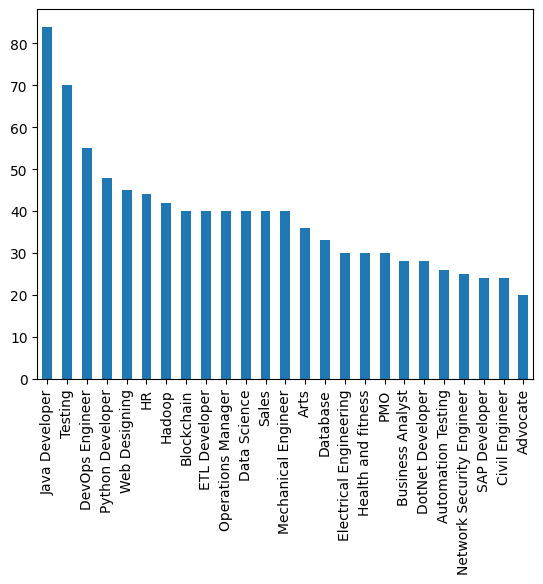

In [7]:
df.Category.value_counts().plot.bar(xlim=0);

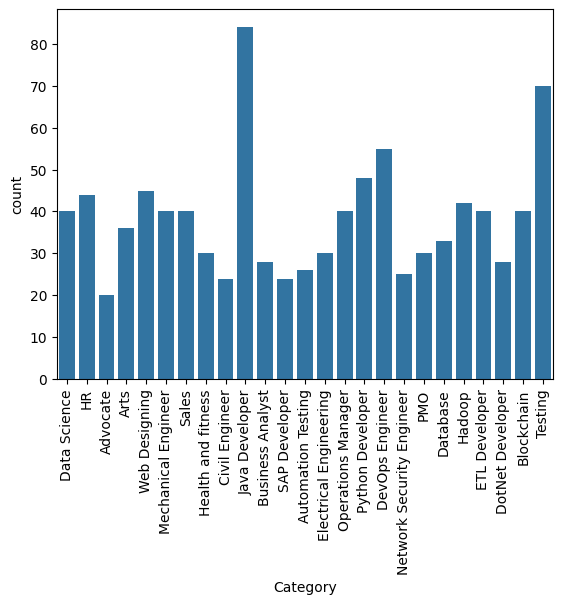

In [8]:
g = sns.countplot(x='Category',data=df)
g.set_xticklabels(labels=df.Category.unique().tolist(), rotation=90)
plt.show()

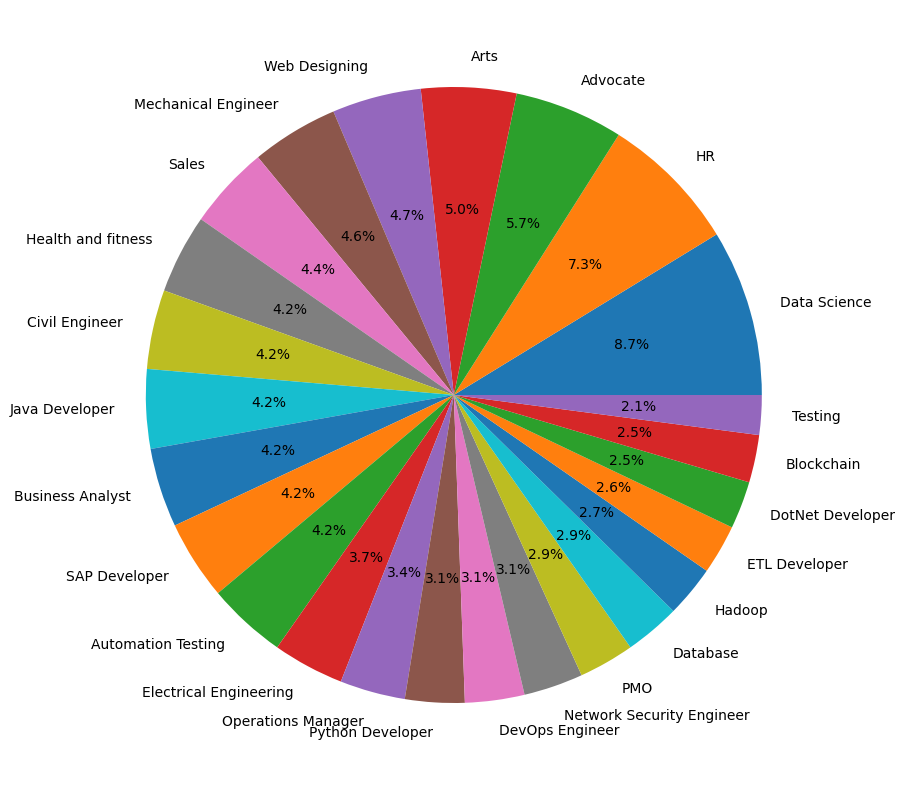

In [10]:
targetLabels  = df['Category'].unique()
targetCounts = df['Category'].value_counts()

# Make square figures and axes
plt.figure(1, figsize=(10,10))
the_grid = GridSpec(2, 2)


g = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%')
plt.show()

In [11]:
# Convert all characters to lowercase
df['Resume'] = df['Resume'].map(str.lower)
df.head()

,Category,Resume
0,Data Science,skills * programming languages: python (pandas...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...
2,Data Science,"areas of interest deep learning, control syste..."
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...
4,Data Science,"education details \r\n mca ymcaust, faridab..."


### Cleaning resumes' text data

In [12]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', '', resumeText)                                                # remove URLs
    resumeText = re.sub('RT|cc', '', resumeText)                                                     # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)                                                      # remove hashtags
    resumeText = re.sub('@\S+', '', resumeText)                                                      # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', resumeText)  # remove punctuations
    resumeText = re.sub('\s+', ' ', resumeText)                                                      # remove extra whitespace
    resumeText = re.sub('â¢', '', resumeText)                                                        # remove special characters

    return resumeText

In [13]:
 # apply the function defined above and save the
df['cleanedresume'] = df['Resume'].apply(cleanResume)
df.head()

,Category,Resume,cleanedresume
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 be uitr...
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana...
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


In [14]:
sent_lens = []
for i in df.cleanedresume:
    length = len(i.split())
    sent_lens.append(length)

print(len(sent_lens))
print(max(sent_lens))

962
2022


### Stopwords removal

The stopwords, for example, `and, the, was, and so forth` etc. appear very frequently in the text and are not helpful in the predictive process. Therefore these are usually removed for text analytics and text classification purposes.

1. Tokenize the input words into individual tokens and store it in an array
2. Using `nltk.corpus.stopwords`, remove the stopwords




In [15]:
# stop words in english language
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

# Exclude 'not' and its other forms from the stopwords list
updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

df['cleanedresume'] = df['cleanedresume'].apply(remove_stopwords)

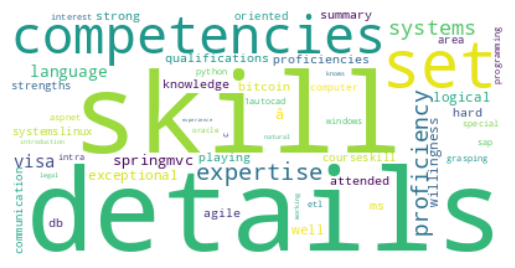

In [17]:
# most common words
text = " ".join(cat.split()[1] for cat in df.cleanedresume)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
le = LabelEncoder()
df['NumericCategory'] = le.fit_transform(df['Category'])
print(df[['Category', 'NumericCategory']])

         Category  NumericCategory
0    Data Science                6
1    Data Science                6
2    Data Science                6
3    Data Science                6
4    Data Science                6
..            ...              ...
957       Testing               23
958       Testing               23
959       Testing               23
960       Testing               23
961       Testing               23

[962 rows x 2 columns]


### Feature Extraction

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df['cleanedresume'], df['NumericCategory'], test_size=.2, random_state = 42)

tv = TfidfVectorizer(max_features=5000)
#transformed train resume text
tfidf_train_resume = tv.fit_transform(x_train)
#transformed test resume text
tfidf_test_resume = tv.transform(x_test)

print('Tfidf_train:', tfidf_train_resume.shape)
print('Tfidf_test:', tfidf_test_resume.shape)

Tfidf_train: (769, 5000)
Tfidf_test: (193, 5000)


## Naive Bayes Classifier

In [20]:
# training the model
mnb = MultinomialNB(alpha=1, fit_prior=True, class_prior=None)

# fitting the NaiveBayes for tfidf features
mnb_tfidf = mnb.fit(tfidf_train_resume, y_train)

print('MultinomialNB for tf-idf :', mnb_tfidf)

MultinomialNB for tf-idf : MultinomialNB(alpha=1)


In [21]:
# predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(tfidf_test_resume)
print('predictions for tf-idf :', mnb_tfidf_predict)

predictions for tf-idf : [15 15 15 13 14 17 16  2  0 14 13 12 16 23 20  5  6  4 10  9 19  1 10 23
 23  6 22 22  2 12 18  1  8 24 11 23  7 12 24  8 18  6  8 19 24 23 21  1
 15  4 15 22 11  5 15 13  1 19  5 12 22 22 20 24 21 18 12 10 10 20 10  8
  9 21 17 21  0 17 16 14 15 11 11  8 20  3 19  8  0  2  9 10  2 23 20 20
 23 15 18 12  7 16  8 14 18  3 14 19 14 14 15 18  8  2 21 18 23 10 23  5
 11 15 12  3  5  3  7 12 19  8 20 19  3 15 15 19  1 23 21  5 20 15 16  7
  7  8 15 18  1 15 13 20  7  4 18 11  5 15  5 12  9 22 18 21  8 23  4 12
 24 16 15 22  8 22  3 16 23 23 12  7 16 18  5  3 18  8 23 23 20  6  6  7
 23]


In [22]:
# accuracy score for tf-idf
mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_predict)
print("mnb_tfidf_score :", mnb_tfidf_score)


mnb_tfidf_score : 0.9844559585492227
